In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [94]:
from astir.data import from_csv_yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import torch
import yaml
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# 1st Level - CL

In [124]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"

In [125]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 4 cell types, 110633 cells


In [129]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   1%|          | 7/1000 [ 3.93s/epochs, current loss: -5098246.2]


Text(0.5, 0, 'Epoch')

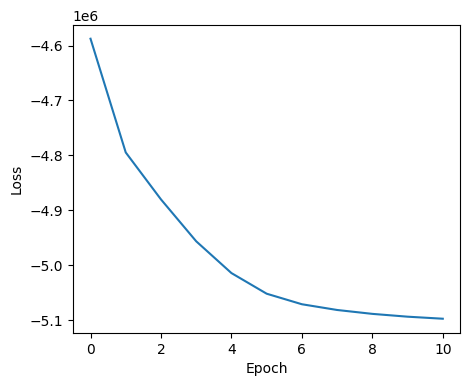

In [130]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [131]:
Astir_result = ast.get_celltypes()

<Axes: xlabel='Cell_type'>

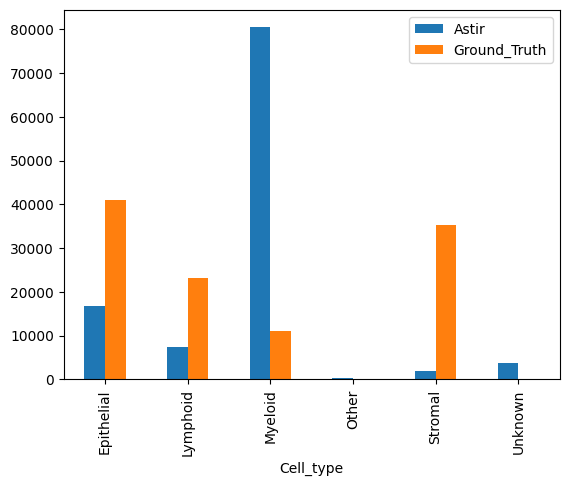

In [132]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

<Axes: >

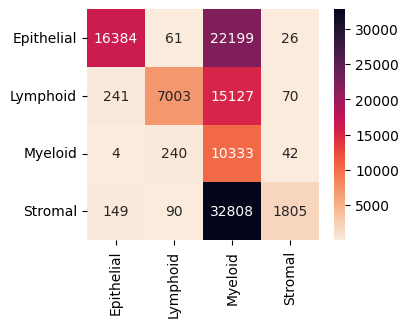

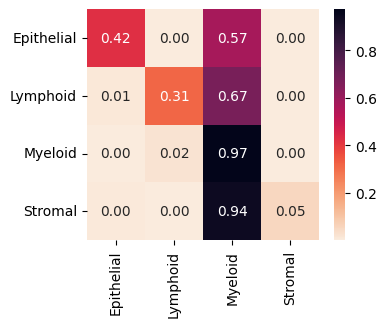

In [133]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# 1st Level - SB

In [134]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_SB.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"

In [135]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 4 cell types, 137652 cells


In [136]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   1%|          | 8/1000 [ 4.25s/epochs, current loss: -6655162.1]


Text(0.5, 0, 'Epoch')

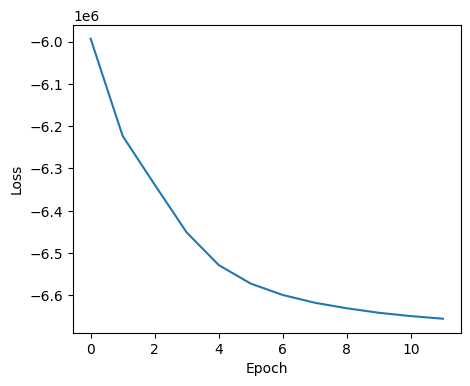

In [137]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [138]:
Astir_result = ast.get_celltypes()

<Axes: xlabel='Cell_type'>

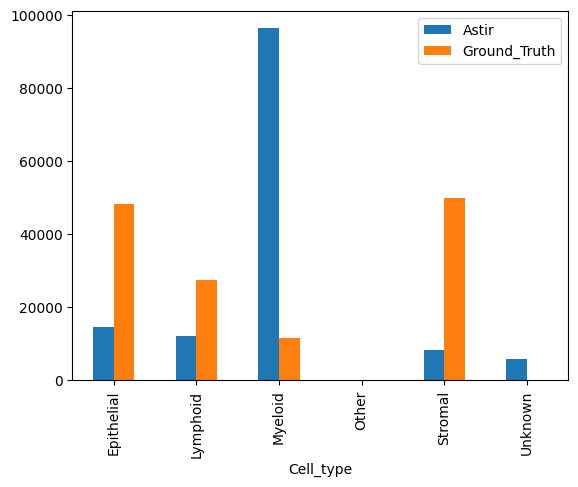

In [139]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

<Axes: >

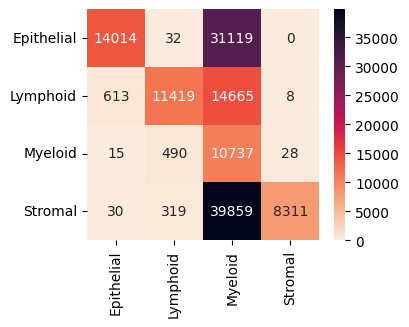

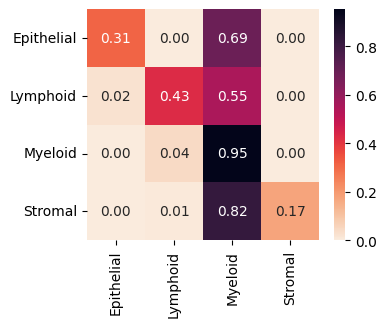

In [140]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# 2nd level

In [141]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir_2lelvel.yml"

In [142]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 14 cell types, 110633 cells


In [144]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   2%|▏         | 21/1000 [ 6.99s/epochs, current loss: -9501427.4]


Text(0.5, 0, 'Epoch')

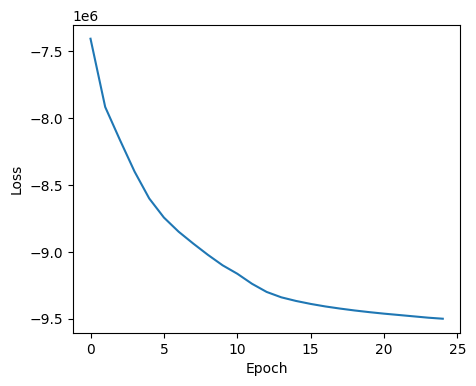

In [145]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [146]:
Astir_result = ast.get_celltypes()

<Axes: xlabel='Cell_type'>

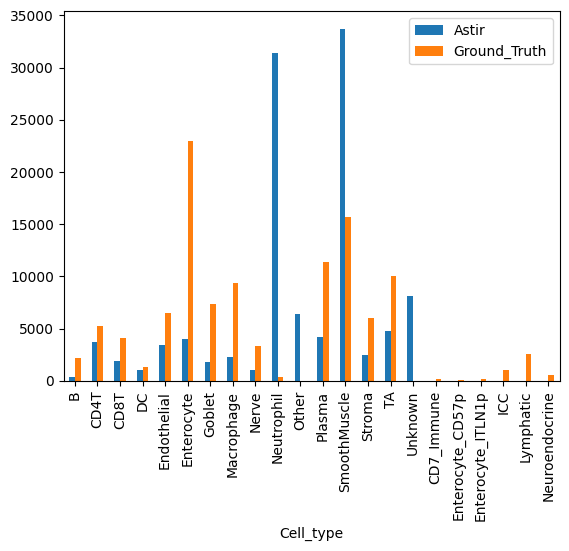

In [147]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_A"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_12632\3757328048.py:16: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7886030684002457, Accuracy score = 0.21599341968490415, Precision score = 0.6390448585000815, F1 score = 0.30939959986781035


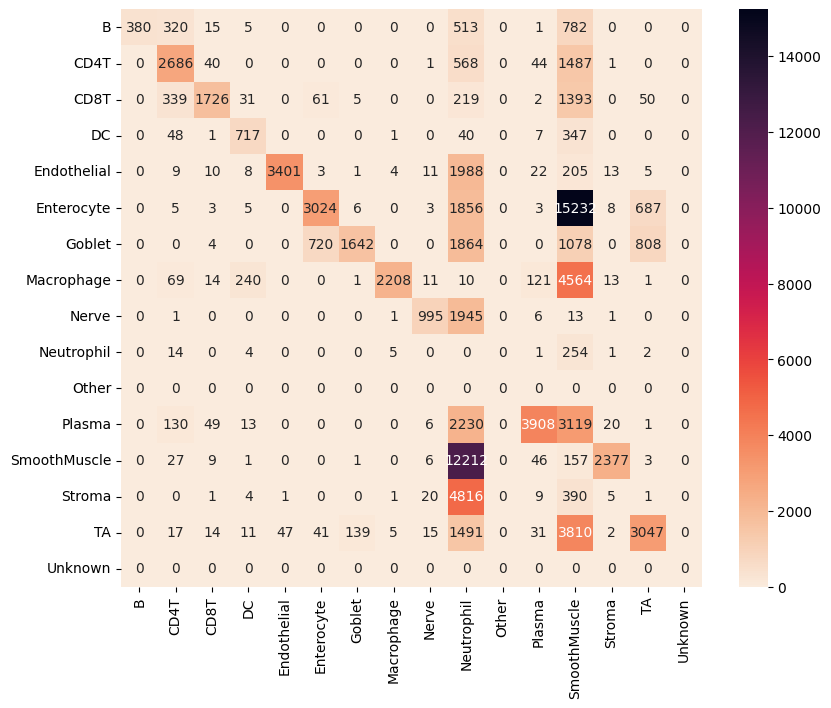

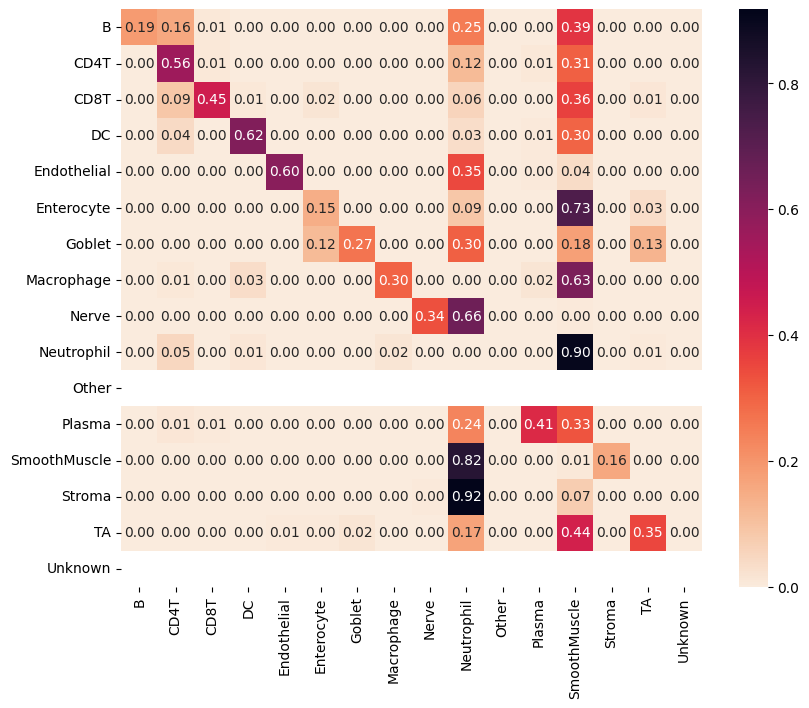

In [148]:
# "original_labels" list of the "ground_truth labels"
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_A"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(astir_labels)
astir_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)

RI = rand_score(original_labels, astir_labels) #between 0-1
AS = accuracy_score(original_labels, astir_labels)
PS = precision_score(original_labels, astir_labels, average='weighted')
F1 = f1_score(original_labels, astir_labels, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))
